## Library Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df_purchase = pd.read_csv('purchase data.csv')

## Data Segmentation

### Import Segmentation model

In [3]:
scaler = pickle.load(open('scaler.pickle','rb'))

pca = pickle.load(open('pca.pickle','rb'))

kmeans_pca = pickle.load(open('kmeans_pca.pickle','rb'))

### Standardization

In [4]:
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income','Occupation', 'Settlement size']]
df_purchase_seg_std = scaler.transform(features)

### PCA 

In [5]:
df_purchase_seg_pca = pca.transform(df_purchase_seg_std)

### K-means PCA

In [6]:
df_purchase_seg_kmeans_pca = kmeans_pca.predict(df_purchase_seg_pca)

df_purchase_predictors = df_purchase.copy()

df_purchase_predictors['Segment'] = df_purchase_seg_kmeans_pca

In [7]:
segment_dummies = pd.get_dummies(df_purchase_seg_kmeans_pca,
                                prefix = 'Segement',
                                prefix_sep='_')
df_purchase_predictors = pd.concat([df_purchase_predictors,
                                  segment_dummies], axis=1)

df_pa = df_purchase_predictors

## Purchase Probability Model

In [8]:
Y = df_pa['Incidence']

In [9]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5']) / 5

In [10]:
model_purchase = LogisticRegression(solver='sag')
model_purchase.fit(X,Y)

LogisticRegression(solver='sag')

In [47]:
model_purchase.coef_

array([[-2.34919758]])

### Price Elasticity of Purchase Probability

In [12]:
df_pa[['Price_1','Price_2','Price_3','Price_4','Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [24]:
price_range = np.arange(0.5,3.5,0.01)

df_price_range = pd.DataFrame(price_range)

In [14]:
Y_pr = model_purchase.predict_proba(df_price_range)

In [21]:
purchase_pr = Y_pr[:][:,1]

$Elasticity = {\frac {\frac{\delta Pr(purchase)}{Pr(purchase)}} {\frac{\delta Price}{Price}}} $


$ Elasticity = {\beta} * price * (1- Pr(purchase) $

In [25]:
pe = model_purchase.coef_[:,0] * price_range * (1 - purchase_pr)

In [26]:
df_price_e = pd.DataFrame(price_range)
df_price_e = df_price_e.rename(columns = {0:'Price_point'})
df_price_e['Mean_e'] = pe

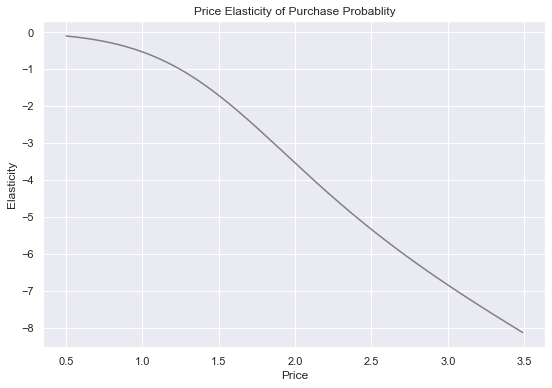

In [28]:
plt.figure(figsize=(9,6))
plt.plot(price_range, pe, color='grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probablity')
plt.show()

***As obvious, increase in price tend to lower the elasticity, but upto 1.1 we see a gradual decrease. <br>
Increase in price from 0-1.25 --> gradual drop in purchase probability <br>
Increse in price above 1.25 --> drasticaly reduce the purchase probability***

### Purchase Probalities by Segment

####  0. Career-Focused

In [ ]:
def plot_elasticity():
    pass

In [57]:
df_pa_s0 = df_pa[df_pa['Segment'] == 0]
Y = df_pa_s0['Incidence']

In [58]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_s1['Price_1'] +
                   df_pa_s1['Price_2'] +
                   df_pa_s1['Price_3'] +
                   df_pa_s1['Price_4'] +
                   df_pa_s1['Price_5']) / 5

In [59]:
model_purchase_s0 = LogisticRegression(solver='sag')

model_purchase_s0.fit(X,Y)

model_purchase_s0.coef_

array([[-1.6362568]])

In [60]:
Y_pr_s0 = model_purchase_s0.predict_proba(df_price_range)

purchase_pr_s0 = Y_pr_s0[:][:,1]

In [61]:
pe_s0 = model_purchase_s0.coef_[:,0] * price_range * (1 - purchase_pr_s0)

In [62]:
df_price_e['PE_S0'] = pe_s0

df_price_e

,Price_point,Mean_e,PE_S1,PE_S0
0,0.50,-0.096434,-0.121688,-0.119534
1,0.51,-0.100505,-0.125830,-0.123638
2,0.52,-0.104702,-0.130059,-0.127830
3,0.53,-0.109030,-0.134376,-0.132110
4,0.54,-0.113492,-0.138782,-0.136480
...,...,...,...,...
295,3.45,-8.017081,-5.305620,-5.392616
296,3.46,-8.042339,-5.324927,-5.412175
297,3.47,-8.067562,-5.344200,-5.431698
298,3.48,-8.092751,-5.363439,-5.451186


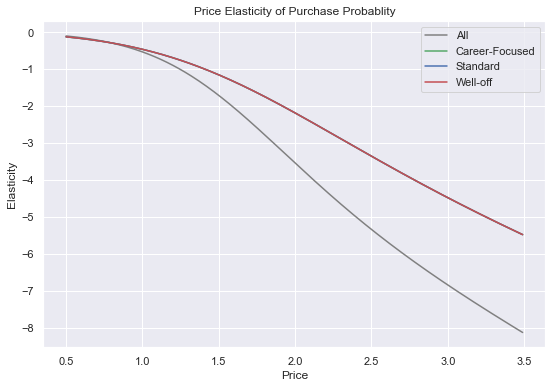

In [67]:
plt.figure(figsize=(9,6))
plt.plot(price_range, pe, color='grey')
plt.plot(price_range, pe_s0, color='g')
plt.plot(price_range, pe_s0, color='b')
plt.plot(price_range, pe_s0, color='r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probablity')
plt.legend(['All','Career-Focused','Standard','Well-off','Few Opportunities'])
plt.show()